In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_theme(style='whitegrid')
# For modelling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Load Data
Data can be downloaded from [Kaggle](https://www.kaggle.com/datasets/wordsforthewise/lending-club?datasetId=902). Information about the columns can be seen here on [google drive](https://drive.google.com/file/d/1UzyKMtrzL3aEEQpeYIz_qjBWyW-lAMr0/view).

In [8]:
accepted_df = pd.read_csv(filepath_or_buffer="../data/raw/accepted_2007_to_2018Q4.csv")
#rejected_df = pd.read_csv(filepath_or_buffer="data/raw/rejected_2007_to_2018Q4.csv")

/var/folders/h0/sqy12xn11_gg038734m010lh0000gn/T/ipykernel_70787/1109698793.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv(filepath_or_buffer="../data/raw/accepted_2007_to_2018Q4.csv")


In [9]:
# Take on subset of the whole data to better work with it
# TODO: Delete this later for the final fit of our model(s)
# Attention: For NaNs Identification etc... use full dataset
n_sample = 50000
accepted_df = accepted_df.sample(n=n_sample)
#rejected_df = rejected_df.sample(n=n_sample)

In [10]:
# Get number of rows apriori of preprocessing
N = accepted_df.shape[0]

# Print information about raw datasets
print(f"Shape of accepted_df: {accepted_df.shape}")
#print(f"Shape of rejected_df: {rejected_df.shape}")

Shape of accepted_df: (50000, 151)


In [11]:
accepted_df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1185985,28633358,NaN,16200.0,16200.0,16200.0,36 months,15.61,566.43,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
944278,107968005,NaN,1000.0,1000.0,1000.0,36 months,11.39,32.93,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1678245,100699302,NaN,10000.0,10000.0,10000.0,36 months,19.99,371.59,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
818355,138304625,NaN,20000.0,20000.0,20000.0,60 months,13.56,460.82,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1249794,19606541,NaN,16800.0,16800.0,16800.0,60 months,14.99,399.59,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning
In this section we remove features that contain too many NaNs and which are also not (or less) relevant for our prediction.

## NaNs Attributes Removal

In [12]:
# Compute fraction of NaNs in each Attribute
null_count_series = accepted_df.isna().sum().div(N)
# Sort descending
null_count_series = null_count_series.sort_values(ascending=False)

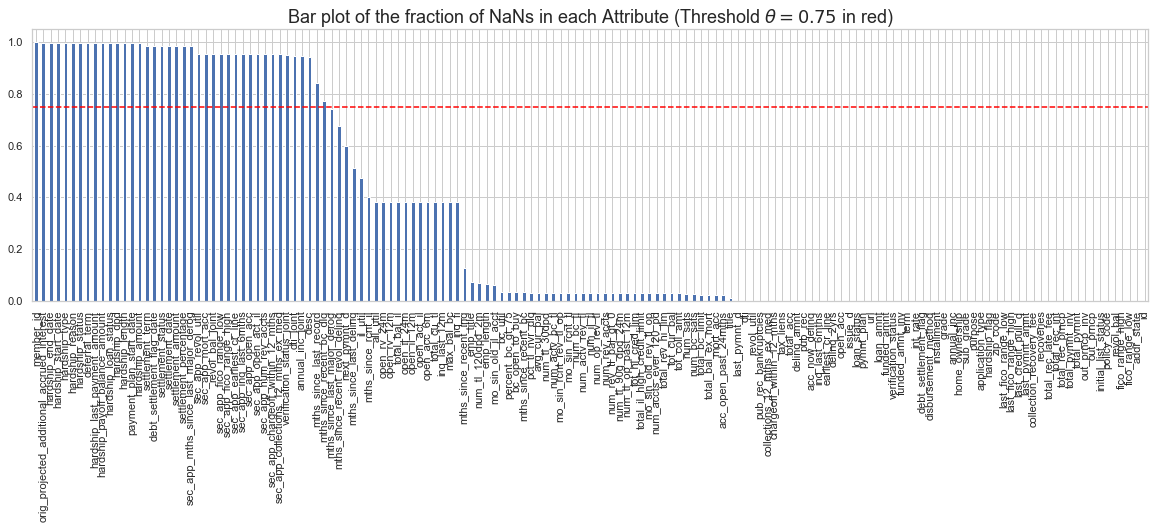

In [13]:
# Define threshold theta: Each column with more or equal NaNs than the threshold will be removed.
threshold = 0.75

plt.figure(figsize=(20,5))
plt.title(f"Bar plot of the fraction of NaNs in each Attribute (Threshold $\\theta = {threshold}$ in red)", size=18)
null_count_series.plot.bar()
# Add threshold as red line
plt.axhline(y=threshold, color="red", linestyle = "--")
plt.show()

In [14]:
# Remove all rows where the NaN Fraction is >= threshold.
null_count_series_cut = null_count_series[null_count_series.values < threshold]

In [15]:
# Get column names of the features with NaN fraction < threshold
columns_post_nan_cut = list(null_count_series_cut.index)
# Keep all columns in accepted_df that are in columns_post_nan_cut
accepted_df = accepted_df.drop([col for col in accepted_df.columns if col not in columns_post_nan_cut], axis=1)

In [16]:
accepted_df.head(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
1185985,28633358,16200.0,16200.0,16200.0,36 months,15.61,566.43,D,D1,Pharmacy tech,...,66.7,0.0,0.0,51087.0,31275.0,15200.0,25687.0,N,Cash,N
944278,107968005,1000.0,1000.0,1000.0,36 months,11.39,32.93,B,B3,NaN,...,NaN,1.0,0.0,33149.0,11091.0,0.0,16249.0,N,Cash,N
1678245,100699302,10000.0,10000.0,10000.0,36 months,19.99,371.59,D,D4,Commercial Lender,...,75.0,0.0,0.0,68250.0,49002.0,11000.0,53650.0,N,Cash,N
818355,138304625,20000.0,20000.0,20000.0,60 months,13.56,460.82,C,C1,Sr Clinical Trials Manager,...,0.0,0.0,0.0,99712.0,49596.0,1600.0,98112.0,N,Cash,N
1249794,19606541,16800.0,16800.0,16800.0,60 months,14.99,399.59,C,C5,MAINTENANCE PLANNER,...,40.0,1.0,0.0,47857.0,21926.0,11900.0,18057.0,N,Cash,N


## Feature Selection based on Description
In this section we remove irrelevant features based on the official details list. For example, the attributes containing dates add no (or less) information for our model(s). Also columns like the 'url' are not relevant. 'emp_title', i.e. job title has too many different categorical values.

TODO: Do Feature Selection BEFORE NaNs Removal

In [17]:
# Define irrelevant columns to drop, also includes columns like 'id' which we cannot use for prediction
irrelevant_columns = ['url', 'zip_code', 'id', 'emp_title', 'issue_d', 'pymnt_plan', 'purpose', 'title', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'disbursement_method', 'debt_settlement_flag', 'hardship_flag']

#accepted_df.drop(irrelevant_columns, axis=1, inplace=True)

In [18]:
# Feature Cleaning

def clean_employment_length(value:str):
    """
    Function to clean and encode the attribute "emp_length"
    :param value: Content of the cell
    :return: Cleaned encoding, i.e. 0 for <1 year, and 10 for more than 10 years employment.
    """
    if value == "< 1 year":
        return 0
    if value == "10+ years":
        return 10
    if value == np.NaN:
        return np.NaN
    # For the rest, i.e. values of the form "x years" -- keep only the numeric value
    return re.sub('[^0-9]','', str(value))

# Remove "years" in "emp_length" and encode values according to the function defined above
accepted_df['emp_length'] = accepted_df['emp_length'].apply(lambda x: clean_employment_length(x))
# Remove suffix in attribute "term"
accepted_df["term"] = accepted_df["term"].apply(lambda x: re.sub('[^0-9]','', str(x)))

In [22]:
accepted_df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
1185985,28633358,16200.0,16200.0,16200.0,36,15.61,566.43,D,D1,Pharmacy tech,...,66.7,0.0,0.0,51087.0,31275.0,15200.0,25687.0,N,Cash,N
944278,107968005,1000.0,1000.0,1000.0,36,11.39,32.93,B,B3,NaN,...,NaN,1.0,0.0,33149.0,11091.0,0.0,16249.0,N,Cash,N
1678245,100699302,10000.0,10000.0,10000.0,36,19.99,371.59,D,D4,Commercial Lender,...,75.0,0.0,0.0,68250.0,49002.0,11000.0,53650.0,N,Cash,N
818355,138304625,20000.0,20000.0,20000.0,60,13.56,460.82,C,C1,Sr Clinical Trials Manager,...,0.0,0.0,0.0,99712.0,49596.0,1600.0,98112.0,N,Cash,N
1249794,19606541,16800.0,16800.0,16800.0,60,14.99,399.59,C,C5,MAINTENANCE PLANNER,...,40.0,1.0,0.0,47857.0,21926.0,11900.0,18057.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088798,124130032,5000.0,5000.0,5000.0,36,9.93,161.18,B,B2,Director of Medical Records,...,0.0,0.0,0.0,260829.0,74733.0,3300.0,81816.0,N,Cash,N
525531,126418569,2000.0,2000.0,2000.0,36,7.97,62.65,A,A5,Realtor,...,0.0,0.0,0.0,28100.0,17008.0,8600.0,18000.0,N,Cash,N
550299,118316377,18000.0,18000.0,18000.0,60,9.44,377.51,B,B1,Teacher,...,0.0,0.0,0.0,73686.0,25202.0,8700.0,64186.0,N,Cash,N
2259243,90407609,10000.0,10000.0,10000.0,36,12.79,335.93,C,C1,"Owner, Acupuncturist",...,100.0,0.0,0.0,225142.0,246341.0,9600.0,206542.0,N,Cash,N


In [21]:
# TODO: Encode categorical values to numeric ones, e.g. with One Hot Encoder
accepted_df.dtypes

#sns.histplot(accepted_df.dtypes.values)
print(accepted_df.dtypes.value_counts())
# Show columns where its type != float64
categorical_columns = accepted_df.dtypes[accepted_df.dtypes != "float64"]
print(categorical_columns)

float64    86
object     25
dtype: int64
id                      object
term                    object
grade                   object
sub_grade               object
emp_title               object
emp_length              object
home_ownership          object
verification_status     object
issue_d                 object
loan_status             object
pymnt_plan              object
url                     object
purpose                 object
title                   object
zip_code                object
addr_state              object
earliest_cr_line        object
initial_list_status     object
last_pymnt_d            object
next_pymnt_d            object
last_credit_pull_d      object
application_type        object
hardship_flag           object
disbursement_method     object
debt_settlement_flag    object
dtype: object


# Create Target Attribute
In this section we create the target attribute 'default' that is either 1, if the owner of the loan defaulted, and 0 otherwise.

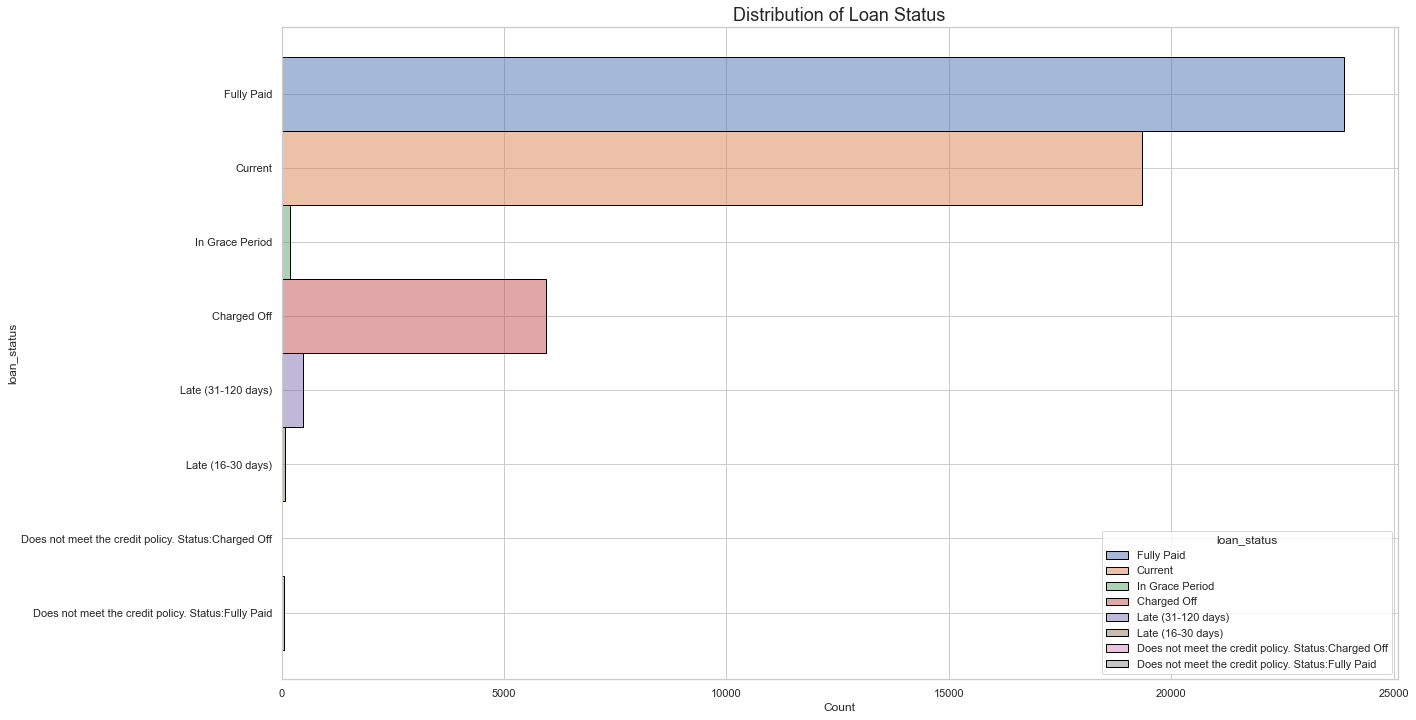

In [62]:
plt.figure(figsize=(20,12))
plt.title("Distribution of Loan Status", size=18)
ax = sns.histplot(data=accepted_df, y="loan_status", edgecolor="black", hue="loan_status")
sns.move_legend(ax, loc="lower right")
plt.show()